In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [58]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.tree import export_text
import graphviz

## Data Loading

In [3]:
data = pd.read_csv('conversion_data.csv')

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [8]:
data_converted = data.loc[data['converted']==1]
avg_conversion_rate = round(len(data_converted)/len(data),3)
avg_conversion_rate

0.032

In [9]:
for col in data.columns:
    print('--------'+col+'--------')
    print(len(data[col].unique()))

--------country--------
4
--------age--------
60
--------new_user--------
2
--------source--------
3
--------total_pages_visited--------
29
--------converted--------
2


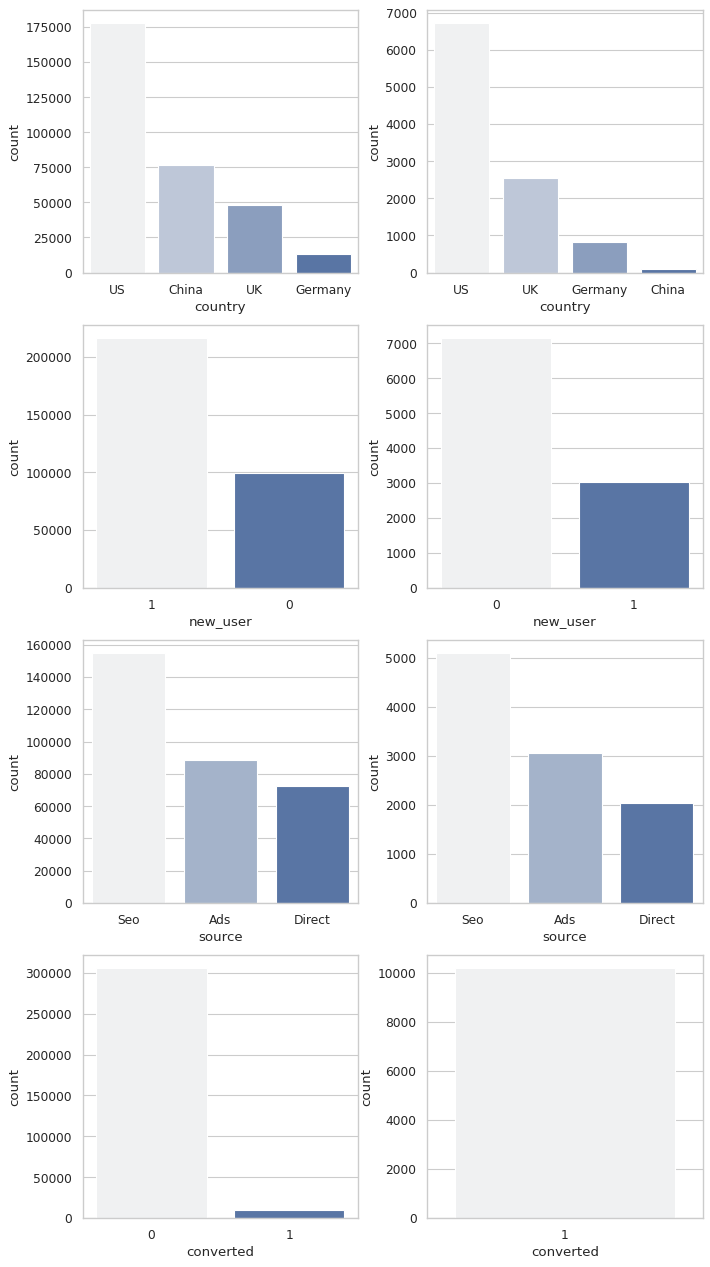

In [11]:
columns = ['country','new_user','source','converted']
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(10,20),dpi=80)
#fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0.2)

i,j = 1,2
for col in columns:
    plt.subplot(4,2,i)
    sns.countplot(data[col],palette="light:b", order = data[col].value_counts().index)
    plt.subplot(4,2,j)
    sns.countplot(data_converted[col],palette="light:b",order = data_converted[col].value_counts().index)
    i += 2
    j += 2

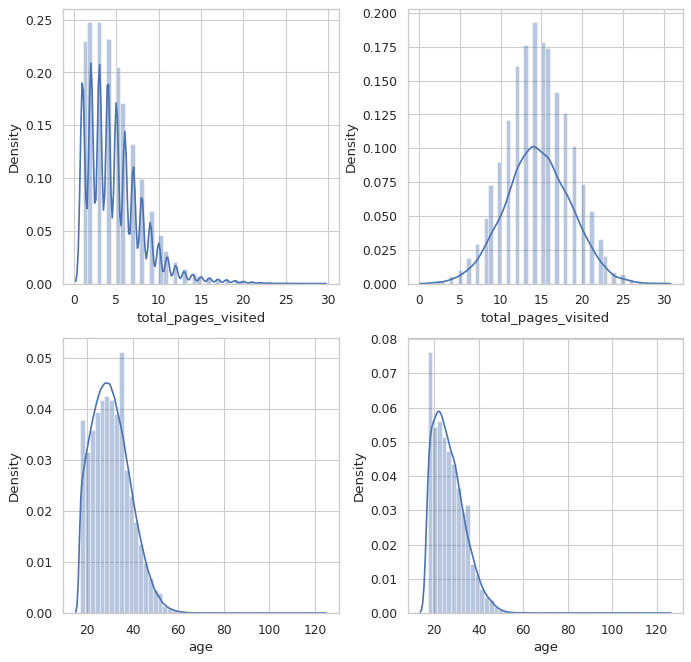

In [13]:
columns = ['total_pages_visited','age']
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(10,10),dpi=80)
#fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0.2)

i,j = 1,2
for col in columns:
    plt.subplot(2,2,i)
    sns.distplot(data[col])
    plt.subplot(2,2,j)
    sns.distplot(data_converted[col])
    i += 2
    j += 2

### Some Observations:
1. The average conversion rate is around 3%.
2. The maximum age is 123, which is unreasonable. Data cleaning is required.
3. User base is pretty young. (Around 20-35)
4. Most of the users are from the US.
5. There are a lot of Chinese users, but the conversion rate is quite low.
6. Old users are more likely to be converted.
7. Seo is the most efficient source.


## Data Cleaning

In [14]:
data = data.loc[~(data['age']>80)]

## Exploratory Analysis

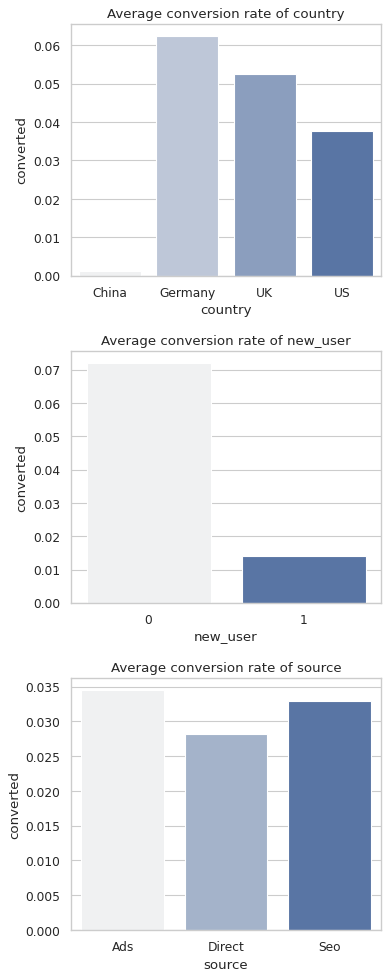

In [16]:
columns = ['country','new_user','source']
sns.set_theme(style="whitegrid")
plt.subplots(figsize = (5,15),dpi=80)
#fig.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0.3)

i = 1
for col in columns:
    plt.subplot(3,1,i)
    plt.title('Average conversion rate of '+col)
    var_converted = pd.DataFrame(data.groupby(col)['converted'].mean()).reset_index()
    sns.barplot(x=col, y='converted',data=var_converted,palette="light:b")
    i += 1
  


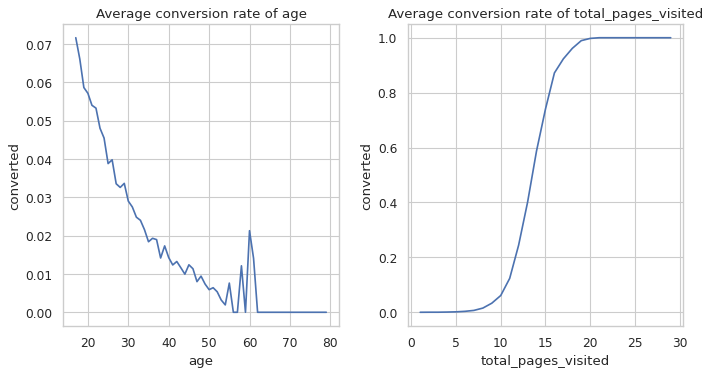

In [17]:
columns = ['age','total_pages_visited']
sns.set_theme(style="whitegrid")
plt.subplots(figsize = (10,5),dpi=80)
#fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0)

i = 1
for col in columns:
    plt.subplot(1,2,i)
    plt.title('Average conversion rate of '+col)
    var_converted = pd.DataFrame(data.groupby(col)['converted'].mean()).reset_index()
    sns.lineplot(x=col, y='converted',data=var_converted)
    i += 1

In [18]:
country_source = data[['country','source']].pivot_table(index='country',columns='source',aggfunc=len,fill_value=0)

In [19]:
country_source_copy = country_source.copy()

In [20]:
country_source_copy['sum'] = country_source.sum(axis=1)
country_source_copy

source,Ads,Direct,Seo,sum
country,,,,
China,21561,17463,37578,76602
Germany,3760,2864,6431,13055
UK,13517,11131,23801,48449
US,49901,40962,87229,178092


In [21]:
country_source_copy = country_source_copy.iloc[:,:-1].div(country_source_copy.iloc[:,-1],axis=0)

Text(0.5, 1.05, 'Source composition by country')

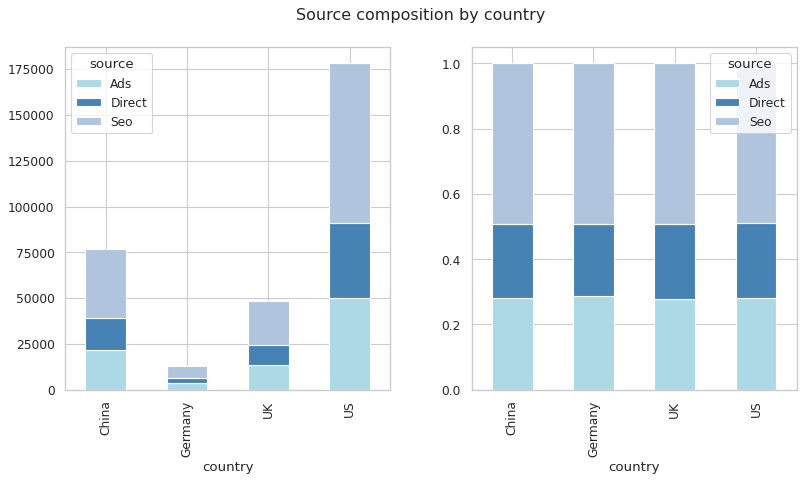

In [23]:
colors = ['lightblue','steelblue','lightsteelblue']
fig,axs = plt.subplots(1,2,figsize=(10,5),dpi=80)
fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0)

country_source.plot.bar(color=colors,ax=axs[0],stacked=True)
country_source_copy.plot.bar(color=colors,ax=axs[1],stacked=True)
plt.suptitle('Source composition by country',y=1.05)


In [24]:
country_converted = data[['country','converted']].pivot_table(index='country',columns='converted',aggfunc=len,fill_value=0)

Text(0.5, 1.05, 'Converted composition by country')

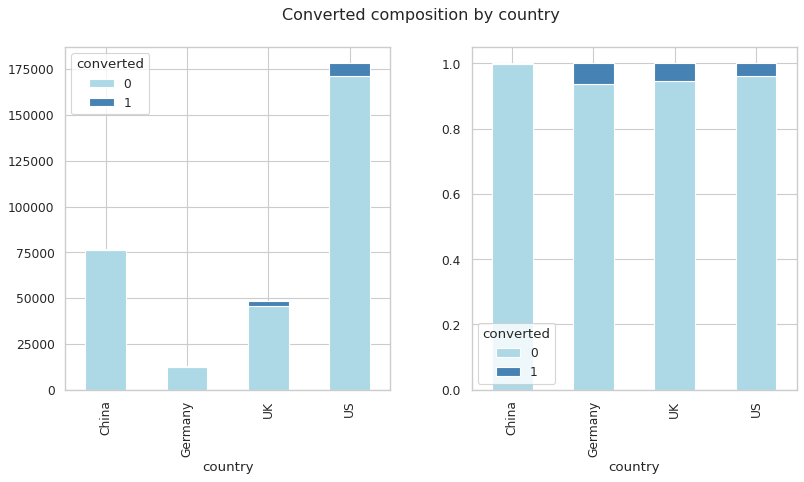

In [25]:
country_converted_copy = country_converted.copy()
country_converted_copy['sum'] = country_converted_copy.sum(axis=1)
country_converted_copy = country_converted_copy.iloc[:,:-1].div(country_converted_copy.iloc[:,-1],axis=0)

fig,axs = plt.subplots(1,2,figsize=(10,5),dpi=80)
fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0)

country_converted.plot.bar(color=colors,ax=axs[0],stacked=True)
country_converted_copy.plot.bar(color=colors,ax=axs[1],stacked=True)
plt.suptitle('Converted composition by country',y=1.05)


Text(0.5, 1.05, 'User composition by source')

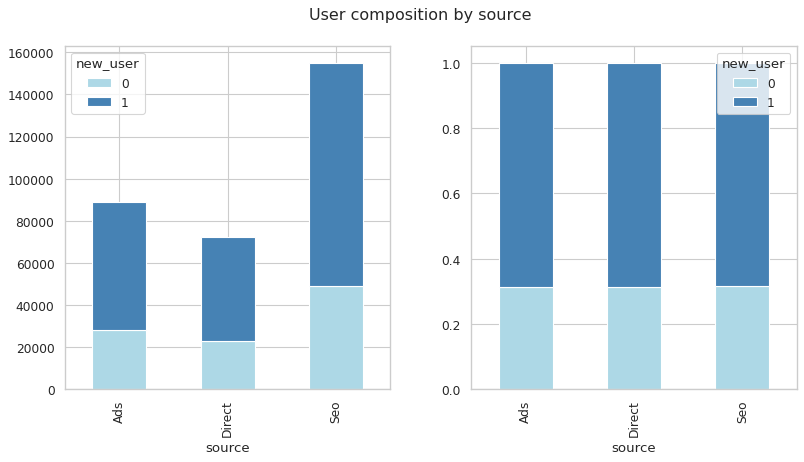

In [26]:
source_new = data[['source','new_user']].pivot_table(index='source',columns='new_user',aggfunc=len,fill_value=0)
source_new_copy = source_new.copy()
source_new_copy['sum'] = source_new_copy.sum(axis=1)
source_new_copy = source_new_copy.iloc[:,:-1].div(source_new_copy.iloc[:,-1],axis=0)

fig,axs = plt.subplots(1,2,figsize=(10,5),dpi=80)
fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0)

source_new.plot.bar(ax=axs[0],stacked=True,color=colors)
source_new_copy.plot.bar(ax=axs[1],stacked=True,color=colors)
plt.suptitle('User composition by source',y=1.05)




Text(0.5, 1.05, 'Converted composition by source')

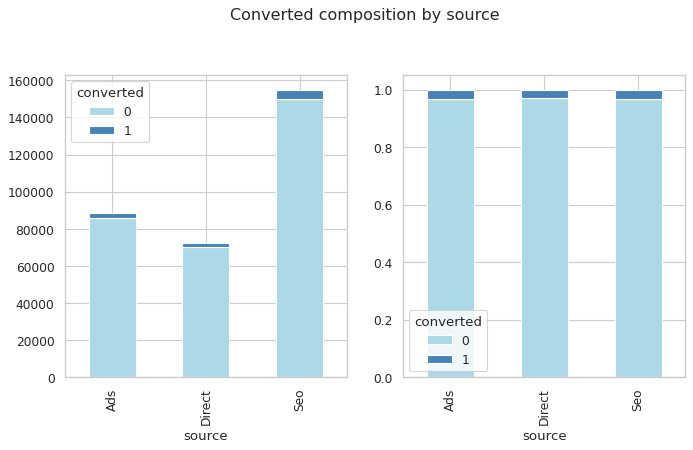

In [27]:
source_converted = data[['source','converted']].pivot_table(index='source',columns='converted',aggfunc=len,fill_value=0)
source_converted_copy = source_converted.copy()
source_converted_copy['sum'] = source_converted_copy.sum(axis=1)
source_converted_copy = source_converted_copy.iloc[:,:-1].div(source_converted_copy.iloc[:,-1],axis=0)

fig,axs = plt.subplots(1,2,figsize=(10,5),dpi=80)



source_converted.plot.bar(ax=axs[0],stacked=True,color=colors)
source_converted_copy.plot.bar(ax=axs[1],stacked=True,color=colors)
plt.suptitle('Converted composition by source',y=1.05)

In [ ]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Text(0.5, 1.0, 'Correlation between variables')

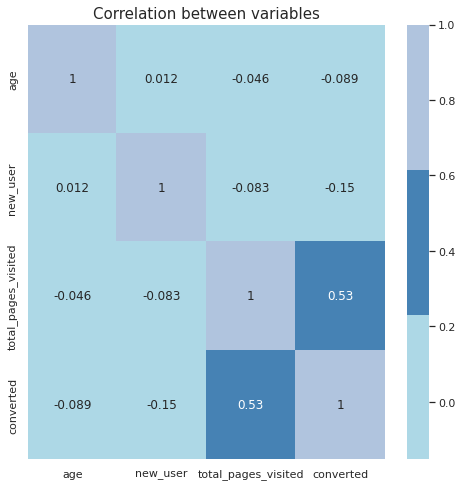

In [28]:
figure(figsize=(8,8))
data_corr = data.corr()
sns.heatmap(data_corr,cmap=colors,annot=True, cbar=True,linecolor='white')
plt.title('Correlation between variables',fontsize=15)

### Some Observations:
1. The conversion rate in China is lower than other countries.
2. Younger users are more likely to be converted.
3. Users who have browsed more pages are more likely to be converted.
4. The source composition by country, user composition by source and converted composition by source are similar.
5. There is an relationship between 'total_pages_visited' and 'converted'.

## Machine Learning

In [29]:
data.head()
data_copy = data.copy()

In [30]:
le = preprocessing.LabelEncoder()
le.fit(data_copy['country'])
data_copy['country'] = le.transform(data_copy['country'])

le1 = preprocessing.LabelEncoder()
le1.fit(data_copy['source'])
data_copy['source'] = le1.transform(data_copy['source'])

In [31]:
data_copy.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


In [32]:
#Under Sample
count = len(data_copy[data_copy['converted']==1])
df_converted = data_copy.loc[data_copy['converted'] == 1]
df_nonconverted = data_copy.loc[data_copy['converted'] == 0]

df_nonconverted = df_nonconverted.sample(n=count, random_state=0)
data_ = pd.concat([df_converted,df_nonconverted],axis=0)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data_.iloc[:,:-1], data_.iloc[:,-1], test_size=0.33, random_state=42)  

In [34]:
#Random Forest
rf = RandomForestClassifier(max_depth=50, random_state=0)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

In [35]:
rf.score(X_train,y_train),rf.score(X_test,y_test)

(0.9694109037687523, 0.9237854702124498)

In [36]:
len(rf.estimators_)

100

Text(0.5, 1.0, 'Confusion Matrix of Random Forest')

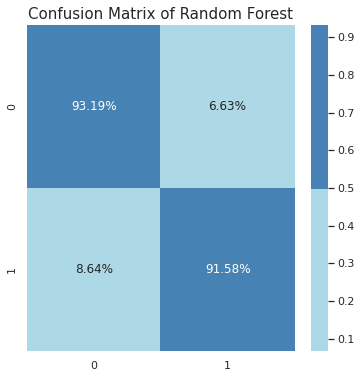

In [37]:
figure(figsize=(6,6))
confusion_mat = confusion_matrix(y_test,y_hat)/confusion_matrix(y_test,y_hat).sum(axis=1)
sns.heatmap(confusion_mat,annot=True,cmap=colors[:2],cbar=True,linecolor='white',fmt='.2%')
plt.title('Confusion Matrix of Random Forest',fontsize=15)

In [38]:
print(classification_report(y_test, y_hat))
             

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3321
           1       0.93      0.92      0.92      3410

    accuracy                           0.92      6731
   macro avg       0.92      0.92      0.92      6731
weighted avg       0.92      0.92      0.92      6731



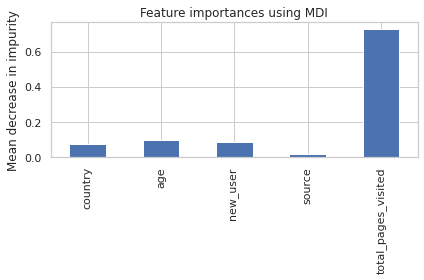

In [42]:
features_names = X_train.columns[:]
importances = rf.feature_importances_
indice = np.argsort(importances)
forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [49]:
dTree = tree.DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
y_hat_d = dTree.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix of Decision Tree')

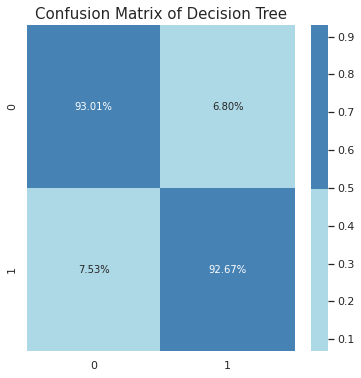

In [50]:
figure(figsize=(6,6))
confusion_mat_d = confusion_matrix(y_test,y_hat_d)/confusion_matrix(y_test,y_hat_d).sum(axis=1)
sns.heatmap(confusion_mat_d,annot=True,cmap=colors[:2],cbar=True,linecolor='white',fmt='.2%')
plt.title('Confusion Matrix of Decision Tree',fontsize=15)

Text(0.5, 1.0, 'Decision Tree')

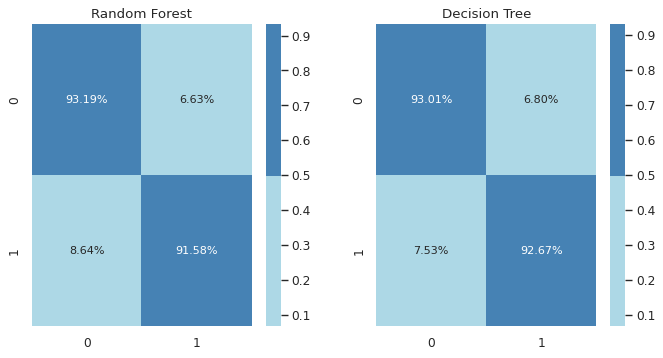

In [51]:
plt.subplots(1,2,figsize=(10,5),dpi=80)
fig.tight_layout()
plt.subplots_adjust(wspace=0.25,hspace=0)

plt.subplot(1,2,1)
sns.heatmap(confusion_mat,annot=True,cmap=colors[:2],cbar=True,linecolor='white',fmt='.2%')
plt.title('Random Forest')

plt.subplot(1,2,2)
sns.heatmap(confusion_mat_d,annot=True,cmap=colors[:2],cbar=True,linecolor='white',fmt='.2%')
plt.title('Decision Tree')

In [52]:
print(classification_report(y_test, y_hat_d))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3321
           1       0.93      0.93      0.93      3410

    accuracy                           0.93      6731
   macro avg       0.93      0.93      0.93      6731
weighted avg       0.93      0.93      0.93      6731



### Plot the Decision Tree

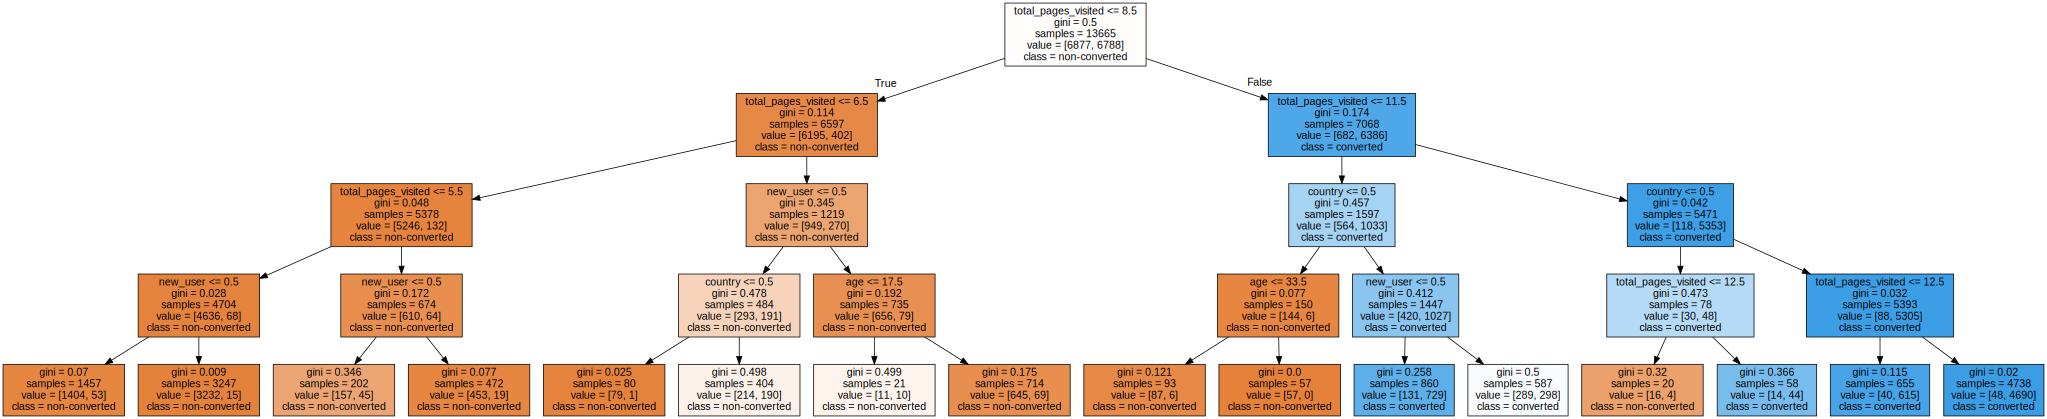

In [56]:
import graphviz
dot_data = tree.export_graphviz(dTree, out_file=None,feature_names=features_names,class_names=['non-converted','converted'],filled=True) 
graph = graphviz.Source(dot_data,format='png') 

graph

In [85]:
feature_names = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
r = export_text(dTree, feature_names=feature_names)
print(r)

|--- total_pages_visited <= 8.50
|   |--- total_pages_visited <= 6.50
|   |   |--- total_pages_visited <= 5.50
|   |   |   |--- new_user <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- new_user >  0.50
|   |   |   |   |--- class: 0
|   |   |--- total_pages_visited >  5.50
|   |   |   |--- new_user <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- new_user >  0.50
|   |   |   |   |--- class: 0
|   |--- total_pages_visited >  6.50
|   |   |--- new_user <= 0.50
|   |   |   |--- country <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- country >  0.50
|   |   |   |   |--- class: 0
|   |   |--- new_user >  0.50
|   |   |   |--- age <= 17.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  17.50
|   |   |   |   |--- class: 0
|--- total_pages_visited >  8.50
|   |--- total_pages_visited <= 11.50
|   |   |--- country <= 0.50
|   |   |   |--- age <= 33.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  33.50
|   |   |   |   |--- class: 0
|   |   |--- country >  0.50


In [65]:
data_

,country,age,new_user,source,total_pages_visited,converted
54,3,25,1,1,18,1
72,3,33,0,2,15,1
87,3,18,0,1,19,1
130,3,17,0,0,19,1
182,3,19,0,0,9,1
...,...,...,...,...,...,...
308247,3,18,1,0,2,0
144408,2,44,0,2,8,0
61317,3,36,0,0,10,0
27606,3,28,0,2,3,0


In [75]:
X,y = data_copy.iloc[:,:-1],data_copy.iloc[:,-1]

In [76]:
X

,country,age,new_user,source,total_pages_visited
0,2,25,1,0,1
1,3,23,1,2,5
2,3,28,1,2,4
3,0,39,1,2,5
4,3,30,1,2,6
...,...,...,...,...,...
316195,3,26,1,0,9
316196,3,27,1,1,6
316197,0,25,0,0,4
316198,3,22,0,2,4


In [78]:
data_copy['prediction_prob'] = rf.predict_proba(X)[:,1]

In [83]:
data_copy.loc[(data_copy['converted']==0)&(data_copy['prediction_prob']>0.5)]

,country,age,new_user,source,total_pages_visited,converted,prediction_prob
25,3,35,1,2,14,0,0.944000
29,3,36,1,1,10,0,0.855833
35,3,33,0,2,11,0,0.521310
39,2,18,1,0,14,0,1.000000
65,3,27,0,0,7,0,0.620500
...,...,...,...,...,...,...,...
316154,3,28,0,0,7,0,0.976667
316161,3,23,0,2,10,0,0.994091
316178,2,25,1,2,11,0,0.885263
316193,2,32,1,1,5,0,0.670000


## Conclusion & Suggestion:
### According to the split principle of Decision Tree:
- ### Marketing
1. We should focus on the users who have visited over 8.5 pages but are not converted. (personized service)

2. We should focus on the non converted users who are predicted to be converted. (personized service)

- ### Products
3. The service for the Chinese users should be improved in order to increase the conversion rate. 